<a href="https://colab.research.google.com/github/pachterlab/GP_2021_3/blob/master/example_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CME methods for scRNA-seq data: a Colab demonstration

## Prerequisites

First, install the prerequisites and pull the scripts from github.

In [1]:
%%capture
!pip install numdifftools 
!pip install parfor
!pip install loompy

Download and unzip cumulative histograms of *n*-long polyA stretches.

In [2]:
%%capture
!wget -O hists.tar.gz https://caltech.box.com/shared/static/mnqqxqm84q5cpreg1tk396cshsld8e03.gz
!tar -xvf hists.tar.gz

In [3]:
# import numpy as np
# import numpy.matlib
# import matplotlib.pyplot as plt
from datetime import date
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
!wget -q -O seq_cme_inference.py https://raw.githubusercontent.com/gennadygorin/velocity-parameter-estimation/master/seq_cme_inference.py?token=AKPPGCRVANGUBZ5QMR23B3TA4TCAC
!wget -q -O driver.py https://raw.githubusercontent.com/gennadygorin/velocity-parameter-estimation/master/driver.py?token=AKPPGCTRYCJGRVNYPK7OOKDA4TE22

In [4]:
from seq_cme_inference import *
from driver import *

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [6]:
import warnings
warnings.filterwarnings("ignore") 

The [10X](https://figshare.com/articles/dataset/10X_protein_and_mRNA_counts/9912734/1?file=17820449) dataset was processed using `kb` for the [protein velocity article](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1945-3), collected from Figshare, and uploaded to Github.

In [65]:
!mkdir -p loom_fbc/
!wget -q -O loom_fbc/pbmc_1k_fbc.loom https://github.com/pachterlab/GP_2021_3/blob/master/loom_fbc/pbmc_1k_fbc.loom

--2021-06-29 21:47:55--  https://github.com/pachterlab/GP_2021_3/blob/master/loom_fbc/pbmc_1k_fbc.loom
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-06-29 21:47:55 ERROR 404: Not Found.



## Inference

The implementation has a driver function. The driver is intended to be run from the command line, and pointed to an input script that defines the search parameters. If the driver is run in notebook, it outputs figures with gene count summaries.

We compare the (`kb`-processed) 10X PBMC feature barcoding dataset to the (`velocyto`-processed) PBMC CITE-seq dataset. Note that the CITE-seq dataset is surprisingly low-expression, so a lot of genes get filtered out; there is not much overlap between the datasets.

In [1]:
!wget -q -O example_input.txt https://raw.githubusercontent.com/pachterlab/GP_2021_3/master/loom_fbc/example_input.txt?token=AKPPGCROXAWIDGFZIQIVC3TA4TL2S

In [2]:
!cat example_input.txt

#Parameter input for CME inference 
dataset_directory : ./loom_fbc/ : folder with dataset loom files
result_directory : ./ : where to put the result folder
loom_filenames : pbmc_1k_fbc : filenames to integrate
transcriptome_filename : gg_200525_genome_polyA_cum_3 : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','CellID']]*2 : list or list of lists with loom attribute names
gene_sel_seed : 123 : gene selection seed
n_gen : 100 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list : : set of result files to import to define gene names
phys_lb : -1, -1.8, -1.8 : log10 of lower bound on burst

['./loom_fbc/pbmc_1k_fbc.loom']
Dataset: ./loom_fbc/pbmc_1k_fbc.loom
64792 features observed, 55712 match genome annotations. 52809 are unique. 
1305 cells detected.
24426 genes retained as high-expression.
2684 genes retained in loom structure based on filter.
Gene set size: 2684
-----------
100 genes selected.
Gene set selected!
64792 features observed, 55712 match genome annotations. 52809 are unique. 
1305 cells detected.
Directory ./gg_210629_pbmc_1k_fbc_5x6_100gen_1 created; metadata written.
30 of 30 points to be evaluated.
starting search...


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Parallelization done!


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Runtime: 1.3 min.


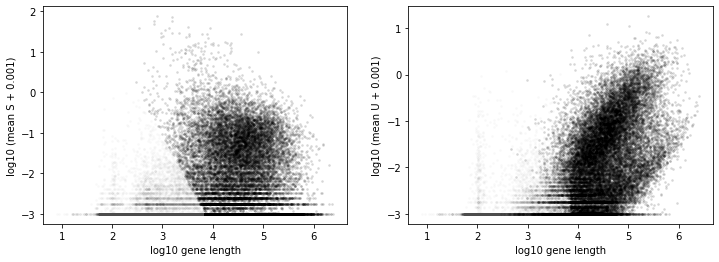

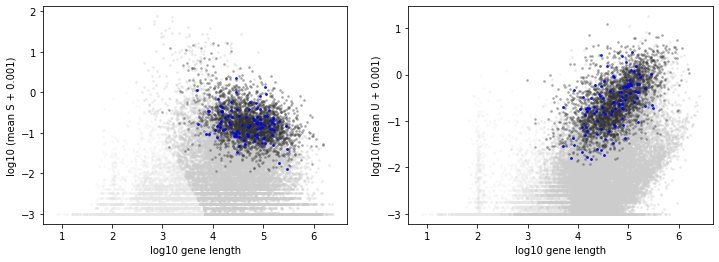

In [7]:
inference_workflow('example_input.txt')

## Result processing

Import the results. The names of the strings in the list should be in the format `./result_dir/result.pickle`. 

In [8]:
result_data = import_datasets(['./gg_210629_pbmc_1k_fbc_5x6_100gen_1/result.pickle'])

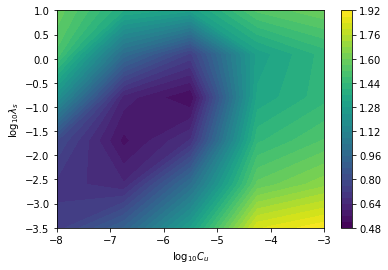

In [9]:
landscape_viz(result_data)

In [10]:
result_data.find_best_params()

In [11]:
result_data.best_samp_params

(-5.5, -0.7999999999999998)

Test how stability of the parameter optimum under resampling.

In [12]:
resamp_vec = np.array(np.linspace(0,result_data.n_gen,6)[1:-1],dtype=int)

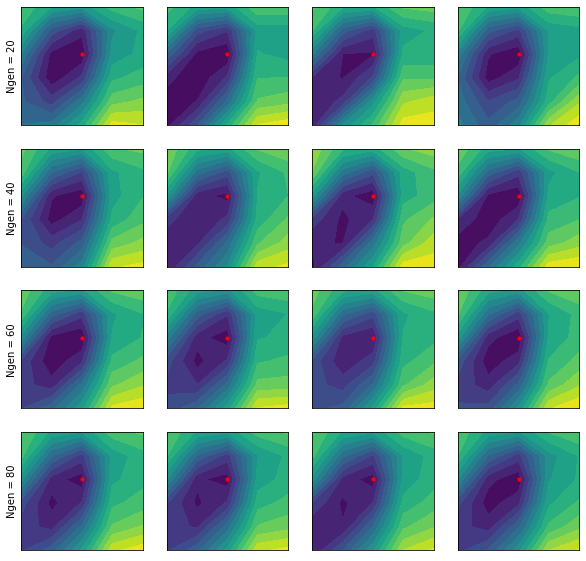

In [13]:
resample_opt_viz(result_data,resamp_vec)

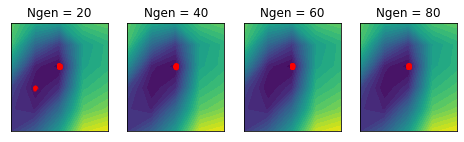

In [14]:
resample_opt_mc_viz(result_data,resamp_vec)

Plot a simple lognormal fit to the parameters, with and without sampling. The parameters clearly show quite a bit of skewness.

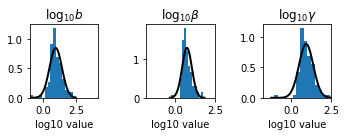

In [15]:
plot_param_marg(result_data)

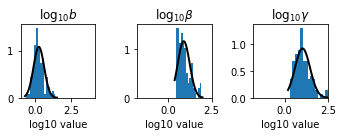

In [16]:
plot_param_marg(result_data,nosamp=True)

Examine length dependence (without error bars on maximum likelihood estimates). The noise-free model shows that the burst size increases with length.

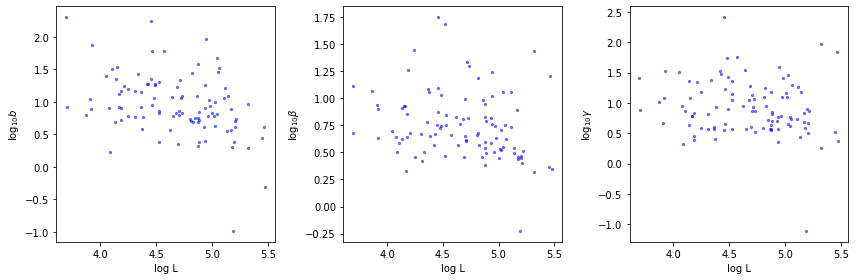

In [17]:
plot_param_L_dep(result_data,plot_errorbars=False)

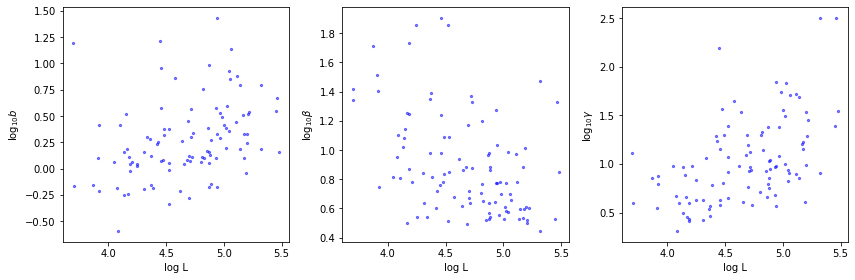

In [18]:
plot_param_L_dep(result_data,plot_errorbars=False,nosamp=True)

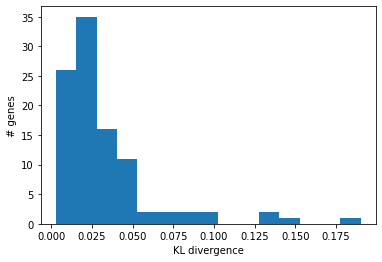

In [19]:
plot_KL(result_data)

In [20]:
(chisq,pval) = chisq_gen(result_data)

Here, outputting pval shows the p-value for the chi-square test. Higher than 0.05/`n_gen`? Everything is fit OK. Lower? The gene is rejected as potentially mis-fit with respect to the model.

Output results of the chi-square test in an array corresponding to 1 = rejected, 0 = not rejected. The number of rejected genes is rather high, but this is not production code.


In [21]:
sz = (10,10) 
figsize = (10,10)
title=True

In [22]:
print(np.array(np.reshape(result_data.gene_rej,sz),dtype=int))

[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [23]:
print(str(np.sum(result_data.gene_rej))+' genes of '+str(result_data.n_gen)+' have been rejected by chi-square.')

3 genes of 100 have been rejected by chi-square.


Compare the actual raw data to the fits. Everything seems to be OK.

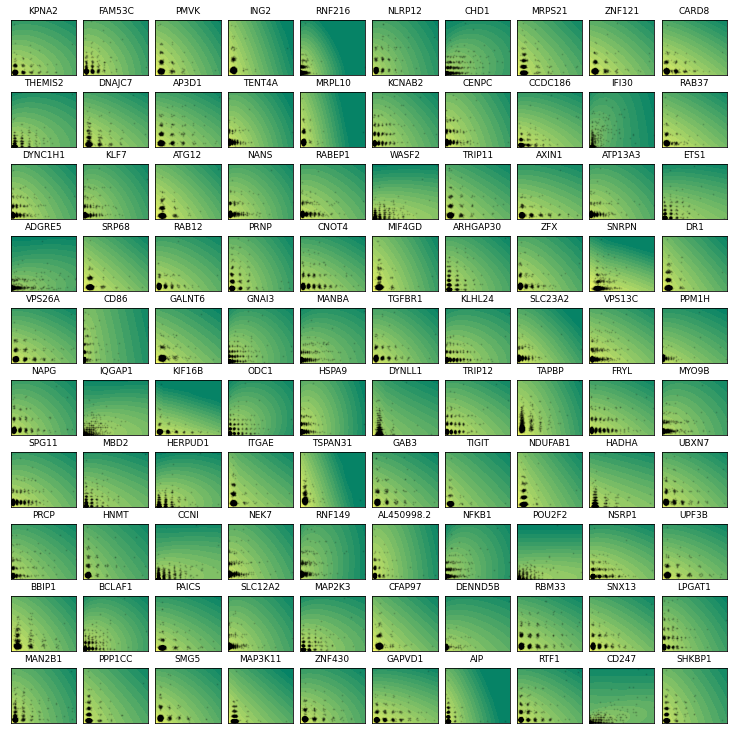

In [24]:
plot_genes(result_data,sz,figsize,'none',log=True,title=title)

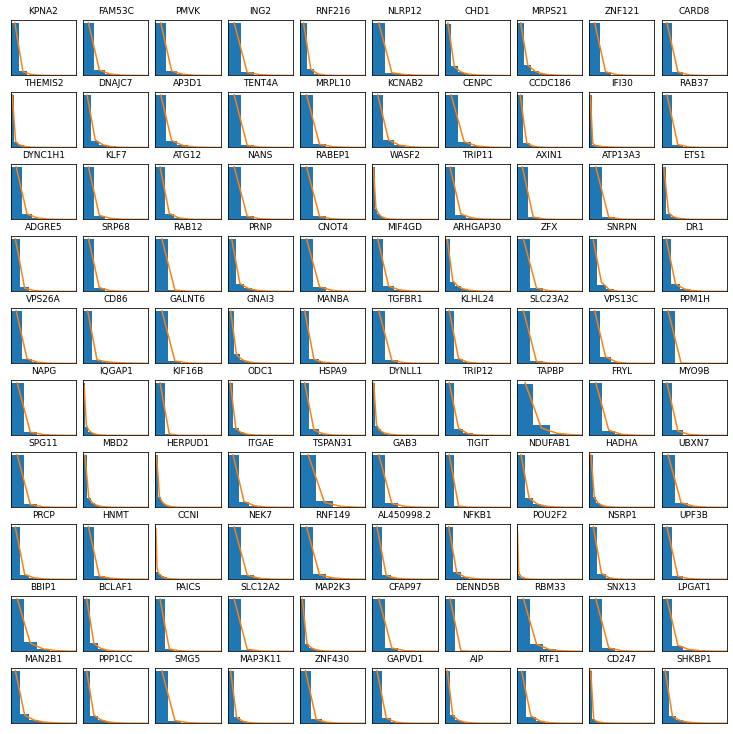

In [25]:
plot_genes(result_data,sz,figsize,'mature',log=False,title=title)

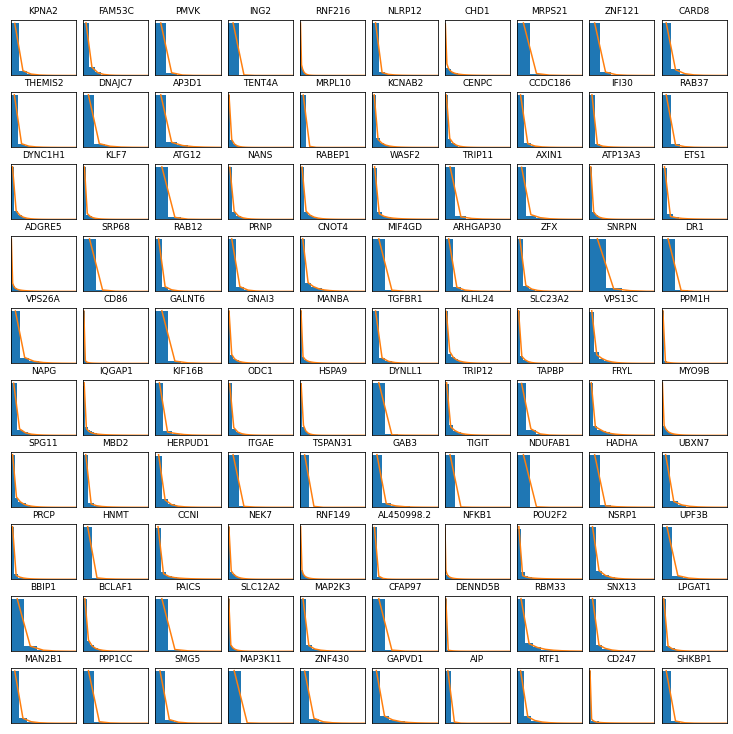

In [26]:
plot_genes(result_data,sz,figsize,'nascent',log=False,title=title)

Test the stability of the optimum under self-consistent chi-squared testing. The optimum does not move.

(-5.5, -0.7999999999999998)

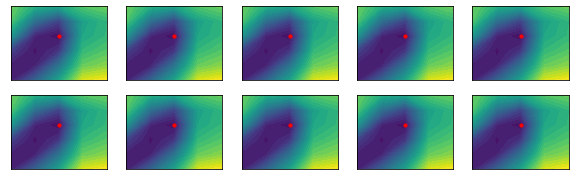

In [27]:
chisq_best_param_correction(result_data,overwrite=True)

##Confidence interval construction

Compute simple 99% confidence intervals for MLEs. These are fairly small, as there are a lot of cells. The genes rejected by the chi-squared test are excluded.

In [28]:
compute_sigma(result_data)
compute_sigma(result_data,nosamp=True)

/content/seq_cme_inference.py:384: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 39 gives negative stdev; replaced with mean. (Search converged to local minimum?)


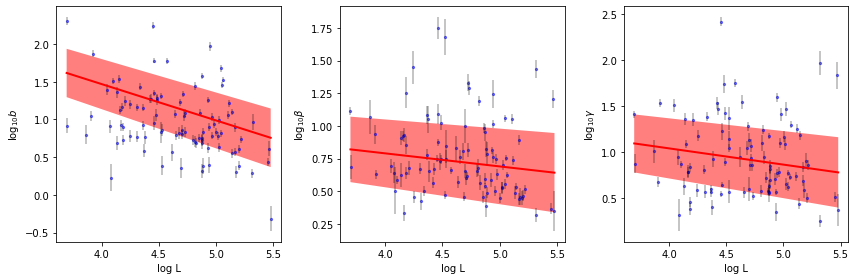

In [29]:
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=False)

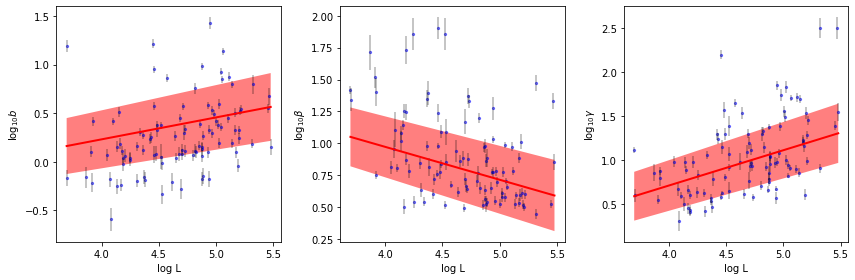

In [30]:
_=chisq_gen(result_data,nosamp=True)
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=True)